# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

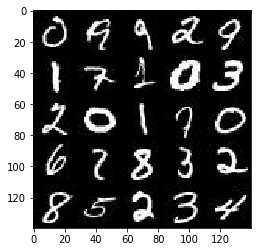

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

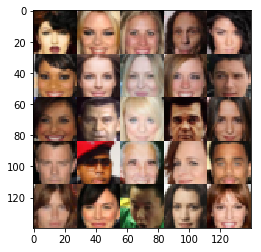

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learningRate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input (Layer 1)
        x1 = tf.layers.conv2d(images, filters=128, kernel_size=(5,5), strides=(2,2), padding='same')
        lrelu1 = tf.maximum(0.2*x1, x1) # Leaky ReLU
        # Now: 14x14x128
        
        # Layer 2
        x2 = tf.layers.conv2d(x1, filters=256, kernel_size=(5,5), strides=(2,2), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True) # Batch normalization
        lrelu2 = tf.maximum(0.2*x2, x2) # Leaky ReLU
        # Now: 7x7x256
        
        # Layer 3
        x3 = tf.layers.conv2d(x2, filters=512, kernel_size=(5,5), strides=(2,2), padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=True) # Batch normalization
        lrelu3 = tf.maximum(0.2*x3, x3) # Leaky ReLU
        # Now: 2x2x512
        
        # Flatten
        flat = tf.reshape(lrelu3, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1) # Output logits
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # If training, no reuse of weights
    if (is_train):
        reuse = False
    else:
        reuse = True
    
    with tf.variable_scope('generator', reuse=reuse):
        # Fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Process for convolutional layers
        x1 = tf.reshape(x1, (-1, 2,2,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train) # Batch normalization
        lrelu1 = tf.maximum(0.2*x1, x1) # Leaky ReLU
        # Now: 2x2x512
        
        # Conv_transpose_1
        x2 = tf.layers.conv2d_transpose(lrelu1, filters=256, kernel_size=(5,5), strides=(2,2), padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train) # Batch normalization
        lrelu2 = tf.maximum(0.2*x2, x2) # Leaky ReLU
        # Now: 7x7x256
        
        # Conv_transpose_2
        x3 = tf.layers.conv2d_transpose(lrelu2, filters=128, kernel_size=(5,5), strides=(2,2), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train) # Batch normalization
        lrelu3 = tf.maximum(0.2*x3, x3) # Leaky ReLU
        # Now: 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu3, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='same')
        output = tf.tanh(logits)
        # 28x28x(out_channel_dim)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Generator
    g_model = generator(input_z, out_channel_dim)
    
    # Discriminator real
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    
    # Discriminator fake (takes g_model as input and shares weights with Discriminator real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Discriminator Loss real
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                                                        labels = tf.ones_like(d_logits_real)))
    
    # Discriminator Loss fake
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                        labels = tf.zeros_like(d_logits_fake)))
    
    # Generator Loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                   labels = tf.ones_like(d_logits_fake)))
    
    # Total Discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Trainable variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize 
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Saver for storing checkpoints
    #saver = tf.train.Saver()
    
    # Image information
    image_width = data_shape[1]
    image_height = data_shape[2]
    if (data_image_mode == "RGB"):
        out_channel_dim = 3
    else:
        out_channel_dim = 1
        
    # Model inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, out_channel_dim, z_dim)
                
    # Losses
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
                
    # Optimizers
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # For sampling
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            b_steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Normalize to [-1,1]
                batch_images = batch_images * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                # Print loss info at 10 steps
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images,
                                            lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images, 
                                            lr: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Show 5x5=25 images at 100 steps
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
        # Save          
        #saver.save(sess, './data/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.4772... Generator Loss: 0.0517
Epoch 1/2... Discriminator Loss: 1.8637... Generator Loss: 7.0633
Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 0.5849
Epoch 1/2... Discriminator Loss: 1.4207... Generator Loss: 0.6596
Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 1.7097
Epoch 1/2... Discriminator Loss: 0.9151... Generator Loss: 0.7263
Epoch 1/2... Discriminator Loss: 1.5470... Generator Loss: 0.6806
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 1.3123
Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 1.5010
Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 0.7380


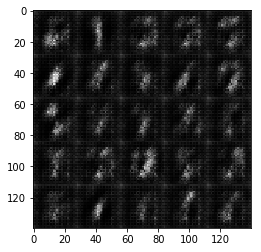

Epoch 1/2... Discriminator Loss: 1.0703... Generator Loss: 1.2907
Epoch 1/2... Discriminator Loss: 1.6415... Generator Loss: 1.4172
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 1.6762
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 1.0623
Epoch 1/2... Discriminator Loss: 1.5116... Generator Loss: 0.9621
Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 0.4940
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 1.1507
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 1.3087


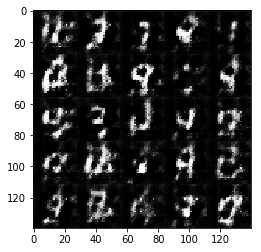

Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 1.0671
Epoch 1/2... Discriminator Loss: 1.2337... Generator Loss: 1.0253
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 1.4662
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 1.1595
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 0.8877
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 0.5231
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 1.0393
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.5022
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 1.3063... Generator Loss: 0.8154


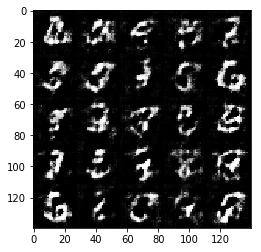

Epoch 1/2... Discriminator Loss: 1.2609... Generator Loss: 0.9274
Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 1.4355
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.9169
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.6592
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.4856
Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 1.2997... Generator Loss: 0.8230
Epoch 1/2... Discriminator Loss: 1.2557... Generator Loss: 0.7003
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 1.0257
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 0.6427


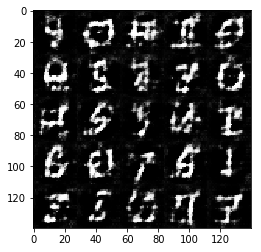

Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.7611
Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 0.8496
Epoch 1/2... Discriminator Loss: 1.3721... Generator Loss: 0.4890
Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 0.6701
Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 0.9181
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 0.5103
Epoch 1/2... Discriminator Loss: 1.2153... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.8240


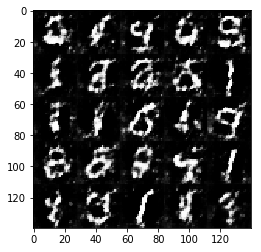

Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 1.0339
Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 1.0498
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 1.0437
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.8581
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.7583
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.2608... Generator Loss: 0.6415
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.7143


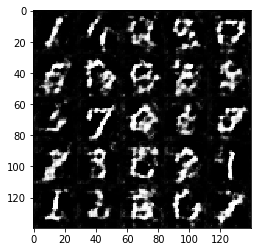

Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.9189
Epoch 1/2... Discriminator Loss: 1.2236... Generator Loss: 0.8806
Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 0.9270
Epoch 1/2... Discriminator Loss: 1.2590... Generator Loss: 0.7161
Epoch 1/2... Discriminator Loss: 1.2527... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 0.8741
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.8776
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.5599
Epoch 1/2... Discriminator Loss: 1.2000... Generator Loss: 0.7906


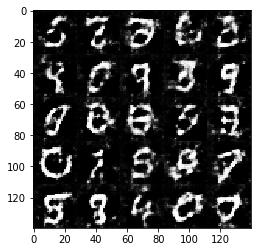

Epoch 1/2... Discriminator Loss: 1.1633... Generator Loss: 0.7328
Epoch 1/2... Discriminator Loss: 1.3534... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 1.3034... Generator Loss: 0.7168
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.5967
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.6029
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 0.9260
Epoch 1/2... Discriminator Loss: 1.2244... Generator Loss: 0.6594
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.8391
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 0.8983


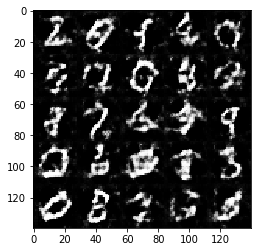

Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.7174
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 1.0803
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.5878
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.7741
Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 0.7419
Epoch 1/2... Discriminator Loss: 1.2821... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 0.8133
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.7553


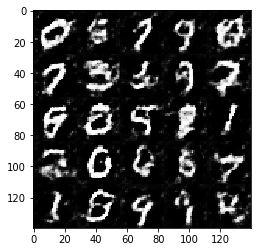

Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 0.6584
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.7805
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.7074
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 1.2728... Generator Loss: 0.8142
Epoch 2/2... Discriminator Loss: 1.2451... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.8172
Epoch 2/2... Discriminator Loss: 1.2730... Generator Loss: 0.6655


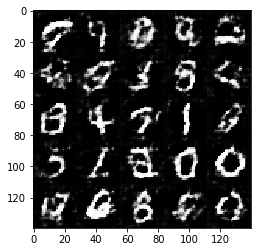

Epoch 2/2... Discriminator Loss: 1.3237... Generator Loss: 0.5592
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 0.6256
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.7565
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.6247
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 1.2065... Generator Loss: 0.7856
Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 0.6359
Epoch 2/2... Discriminator Loss: 1.3628... Generator Loss: 0.6094
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.9065


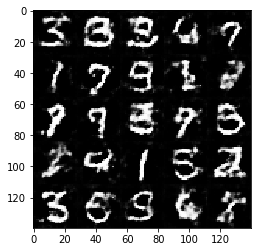

Epoch 2/2... Discriminator Loss: 1.2698... Generator Loss: 0.7915
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.8457
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.7517
Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 0.6381
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 0.6404
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.7068
Epoch 2/2... Discriminator Loss: 1.2436... Generator Loss: 0.7872
Epoch 2/2... Discriminator Loss: 1.2874... Generator Loss: 0.6359
Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 0.6529
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.8039


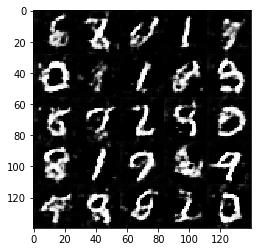

Epoch 2/2... Discriminator Loss: 1.2439... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 0.7501
Epoch 2/2... Discriminator Loss: 1.2722... Generator Loss: 0.8315
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 0.6810
Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 0.8141
Epoch 2/2... Discriminator Loss: 1.2934... Generator Loss: 0.6134
Epoch 2/2... Discriminator Loss: 1.2931... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.6858
Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 0.6853


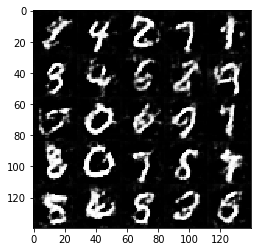

Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 0.8782
Epoch 2/2... Discriminator Loss: 1.2827... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 1.3261... Generator Loss: 0.5725
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.7462
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.9121
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 0.6239
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.7114
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 0.8210


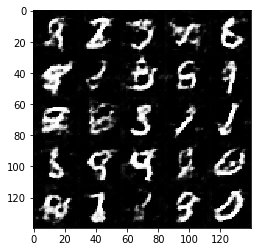

Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.8825
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.8310
Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 0.7364
Epoch 2/2... Discriminator Loss: 1.3248... Generator Loss: 0.6139
Epoch 2/2... Discriminator Loss: 1.3194... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 0.6775
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.2921... Generator Loss: 0.7788
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.5606


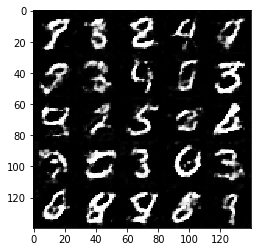

Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.5277
Epoch 2/2... Discriminator Loss: 1.3685... Generator Loss: 0.5675
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.7724
Epoch 2/2... Discriminator Loss: 1.2419... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.5073
Epoch 2/2... Discriminator Loss: 1.2762... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 0.6870
Epoch 2/2... Discriminator Loss: 1.2991... Generator Loss: 0.6801
Epoch 2/2... Discriminator Loss: 1.2488... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 1.2945... Generator Loss: 0.6552


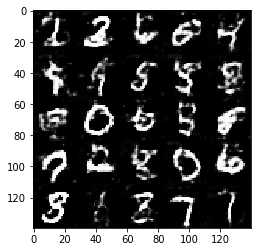

Epoch 2/2... Discriminator Loss: 1.2892... Generator Loss: 0.6421
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.7316
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 0.8421
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 0.6882
Epoch 2/2... Discriminator Loss: 1.2744... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 0.7438
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.7787
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 0.8442


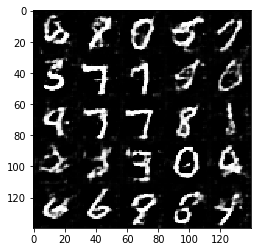

Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 1.3242... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.8728
Epoch 2/2... Discriminator Loss: 1.2484... Generator Loss: 0.9358
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.6693
Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.6172
Epoch 2/2... Discriminator Loss: 1.2286... Generator Loss: 0.6543
Epoch 2/2... Discriminator Loss: 1.2724... Generator Loss: 0.7290
Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 0.7403


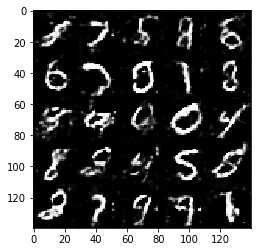

Epoch 2/2... Discriminator Loss: 1.2877... Generator Loss: 0.8264
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 1.2866... Generator Loss: 0.6616
Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.8714
Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 0.5887
Epoch 2/2... Discriminator Loss: 1.3237... Generator Loss: 0.5866


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 5.4248... Generator Loss: 0.0155
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.9715... Generator Loss: 0.2441
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.8761... Generator Loss: 0.3154
Epoch 1/1... Discriminator Loss: 1.6205... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 1.0867


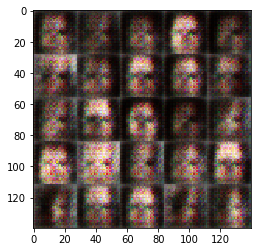

Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 1.2183
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 1.1983
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7631


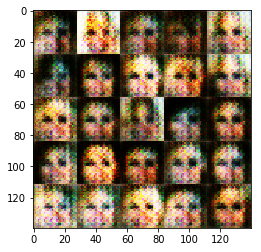

Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.8989


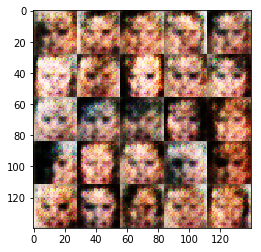

Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.3755
Epoch 1/1... Discriminator Loss: 1.6679... Generator Loss: 1.7692
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7256


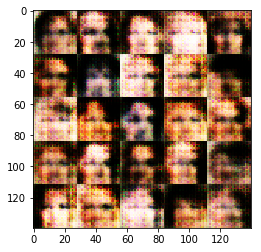

Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6913


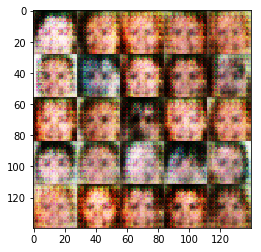

Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7013


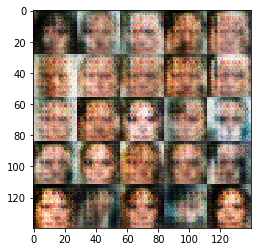

Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7074


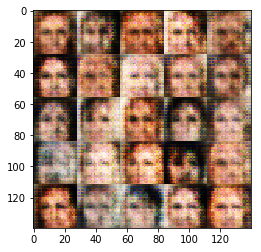

Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7078


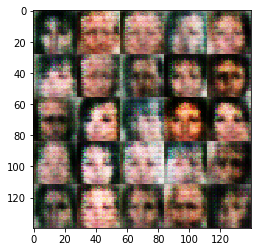

Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6799


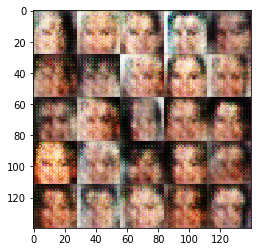

Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7094


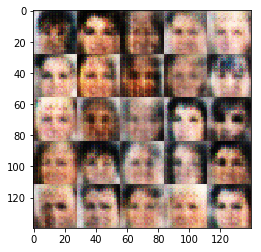

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7355


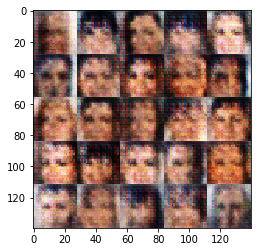

Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7103


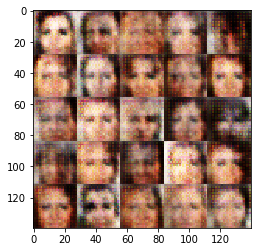

Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7426


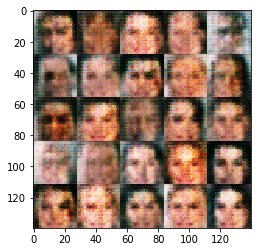

Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7103


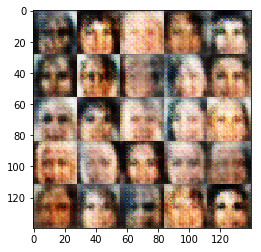

Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.6732


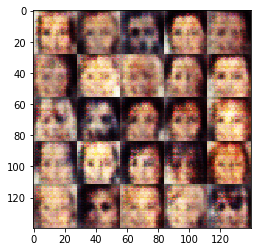

Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6602


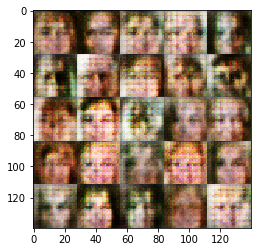

Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.6110


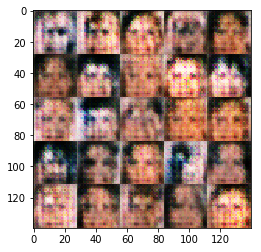

Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7035


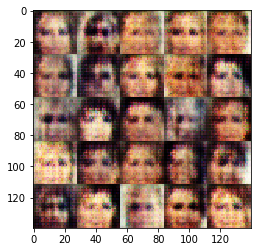

Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7918


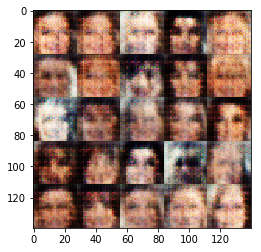

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7441


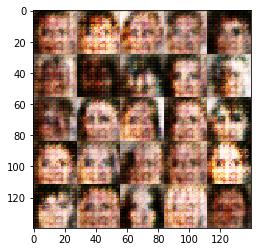

Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6572


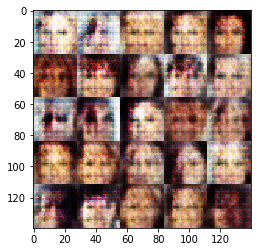

Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6938


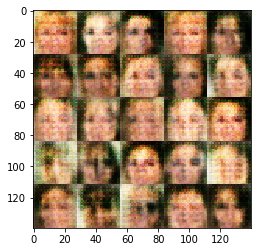

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7001


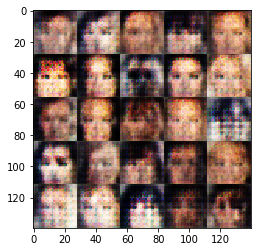

Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6590


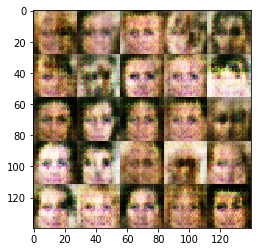

Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7619


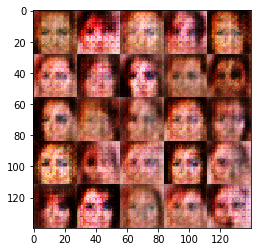

Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6831


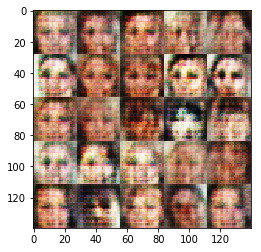

Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6791


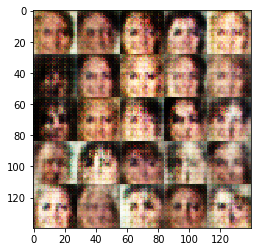

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6834


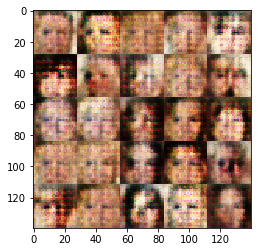

Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6559


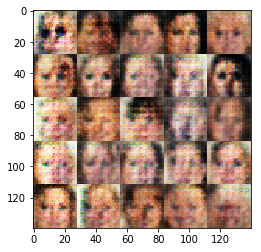

Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7163


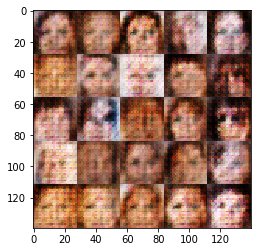

Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6713


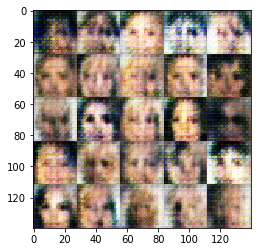

Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6509


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.